In [2]:
%matplotlib inline
import csv
import string
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

data_dict = {}
GPSS_FILE = 'surveyResults_AllGPSS_True.csv'
GSAS_FILE = 'surveyResults_1PassCleanGradStudents.csv'
NUM_DATASETS = 2

print('Complete')

Complete


In [3]:
def get_data(file):
    data = pd.read_csv(file, encoding = "ISO-8859-1")
    return data.drop(data.index[1]) # Remove non-data rows

def clean_string(string, min_width=10):
    last_break = 0
    i = 0
    while i < len(string):
        if i > last_break + min_width and string[i] == ' ':
            string = string[:i] + '\n' + string[i:]
            last_break = i + 2
            i += 1
        i += 1
    return string

def clean_strings(str_list, min_width=10):
    new_list = []
    for string in str_list:
        new_list.append(clean_string(string))
    return new_list

def hist_from_diff(data1, data2, col, split=True, **kwargs):
    counts_dict1, length1 = get_counts_dict(data1, col, split, **kwargs)
    counts_dict2, length2 = get_counts_dict(data2, col, split, **kwargs)

    counts_dict = {}
    for key in counts_dict1:
        if key in counts_dict2:
            counts_dict[key] = counts_dict1[key] - counts_dict2[key]
        else:
            counts_dict[key] = counts_dict1[key]
    length = length1 - length2

    return plot_hist(counts_dict, length, **kwargs)

def hist_from_column(data, col, split=True, **kwargs):
    counts_dict, length = get_counts_dict(data, col, split, **kwargs)
    return plot_hist(counts_dict, length, **kwargs)

def get_counts_dict(data, col, split=False, parse=False, count_nan=False, **kwargs):
    column = data[col][2:]
    length = len(column)
    if parse:
        column = list(filter(lambda val: isinstance(val, str), column))
        translator = str.maketrans(dict.fromkeys(string.punctuation))
        column = ' '.join(column).lower().translate(translator).split(' ')
        column = list(filter(None, column))
        column2 = [' '.join(column[i:i+2]) for i in range(len(column)-1)]
        column3 = [' '.join(column[i:i+3]) for i in range(len(column)-1)]
        column += column2 + column3
    if split:
        split_column = []
        for item in column:
            if item is not np.nan and ',' in item:
                split_column.extend(item.split(','))
            else:
                split_column.append(item)
        column = split_column

    counts_dict = Counter(column)
        
    if np.nan in counts_dict.keys():
        if not count_nan:
            length -= counts_dict[np.nan]
        counts_dict.pop(np.nan)
        
    if parse:
        for key in list(counts_dict):
            if counts_dict[key] < 2:
                counts_dict.pop(key)
    
    return counts_dict, length

def plot_hist(counts_dict, length=None, norm=True, responses=None,
              label='', ax=None, offset=0.0, width=0.9, sort=False, **kwargs):
    if responses is None:
        responses = list(counts_dict.keys())    
    for r in responses:
        if r not in counts_dict:
            counts_dict[r] = 0
            
    counts = np.array([counts_dict[r] for r in responses])
    if norm and length is None:
        total_counts = np.array(list(counts_dict.values()))
        length = total_counts.sum()
    if norm:
        counts = counts / length * 100

    if sort:
        counts, responses = (t for t in zip(*sorted(zip(counts, responses), reverse=True)))

    indices = np.arange(len(responses), dtype='float64')
    if offset is not None:
        indices += offset

    if ax is None:
        fig, ax = plt.subplots()
    ax.barh(indices, counts, width, label=label)
    ax.set_yticks(indices - offset/2)
    
    ax.set_yticklabels(clean_strings(responses), rotation=0, ha='right')
    if sort:        
        ax.invert_yaxis()
    
    if norm:
        ax.set_xlabel('percent of responses')
    else:
        ax.set_xlabel('responses')
    
    return responses

def compare_columns(data, col1, col2, r1, r2, ax=None, n_col=6, sort=True, norm=False):
    counts = dict.fromkeys(r1)
    for key in counts:
        counts[key] = dict.fromkeys(r2, 0)
    
    if ax is None:
        fig, ax = plt.subplots(1, len(r1), sharey=True)        
    sort = sort
    width = 1 / (len(r1)+1)
    for i, resp in enumerate(r1):
        if n_col > 1:
            for j in range(1,7):
                q1 = '{}_{}'.format(col1, j)
                q2 = '{}_{}'.format(col2, j)
                count = Counter(data[1:][q2][(data[q1] == resp)])
                for key in counts[resp]:
                    counts[resp][key] += count[key]
        else:
            count = Counter(data[1:][col2][(data[col1] == resp)])
            for key in counts[resp]:
                counts[resp][key] += count[key]
        r2 = plot_hist(counts[resp], responses=r2, ax=ax[i], sort=sort, norm=norm)
        ax[i].set_title(clean_string(resp))
        sort = False

GPSS_DATA = get_data(GPSS_FILE)
GSAS_DATA = get_data(GSAS_FILE)
    
print('Complete')

Complete


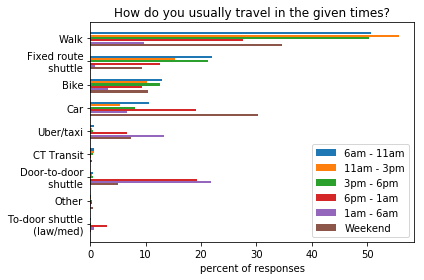

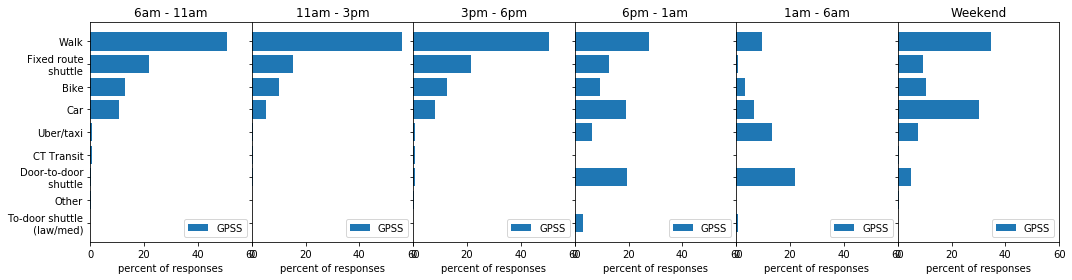

In [822]:
# Question 1: How do you usually travel in the given times?

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots(1,6, sharey=True, figsize=[15,4])
ax2 = ax2.flatten()
sort = True
r = ['Walk', 'Bike', 'Car', 'Fixed route shuttle', 'Door-to-door shuttle', 'CT Transit', 'Uber/taxi', 'To-door shuttle (law/med)', 'Other']
for i in range(1,7):
    q = 'Q1_{}'.format(i)
    ax = ax2[i-1]
    
    r = hist_from_column(GPSS_DATA, q, label=GPSS_DATA[q][0].split(') - ')[-1], ax=ax1, offset=0.1*i, width=0.09, responses=r, sort=sort)
    
    hist_from_column(GPSS_DATA, q, label='GPSS', ax=ax, offset=0.0, width=0.8, responses=r)
#     hist_from_column(GSAS_DATA, q, label='GSAS', ax=ax, offset=0.25, width=0.25, responses=r)
#     hist_from_diff(GPSS_DATA, GSAS_DATA, q, label='PROF', ax=ax, offset=0.5, width=0.25, responses=r)
    ax.set_title(GPSS_DATA[q][0].split(') - ')[-1])
    ax.legend(loc=4)
    sort = False

ax2[0].invert_yaxis()
for ax in ax2: ax.set_xlim(0, 60)
fig2.tight_layout()
fig2.subplots_adjust(wspace=0)
fig2.savefig('plots/Q1_comp.png')    
    
ax1.set_title('How do you usually travel in the given times?')
ax1.legend()
fig1.tight_layout()
fig1.savefig('plots/Q1.png')

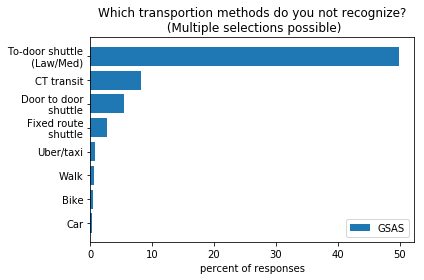

In [801]:
# Question 2: Which transportation methods have you not heard of?

fig, ax = plt.subplots()
r = ['To-door shuttle (Law/Med)', 'CT transit', 'Door to door shuttle', 'Fixed route shuttle', 'Uber/taxi', 'Walk', 'Bike', 'Car']
r = hist_from_column(GSAS_DATA, 'Q2', ax=ax, label='GSAS', responses=r, offset=0.0, width=0.8, count_nan=True, sort=True)
# hist_from_column(GSAS_DATA, 'Q2', ax=ax, label='GSAS', responses=r, offset=0.25, width=0.25, count_nan=True)
# hist_from_diff(GPSS_DATA, GSAS_DATA, 'Q2', ax=ax, label='PROF', responses=r, offset=0.5, width=0.25, count_nan=True)
ax.set_title(clean_string('Which transportion methods do you not recognize? (Multiple selections possible)', 40))
ax.legend(loc=4)
fig.tight_layout()
fig.savefig('plots/Q2.png')

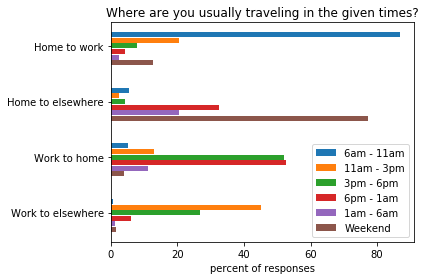

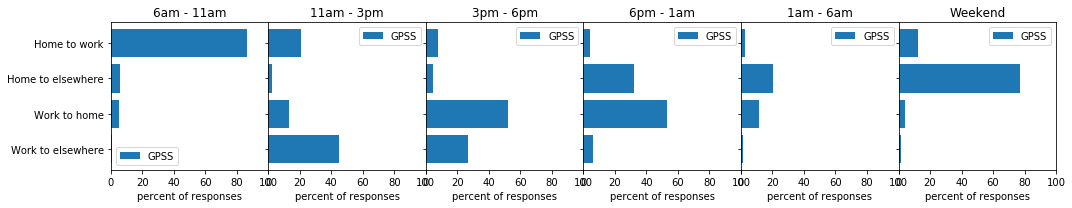

In [811]:
# Question 21: Where are you usually traveling in the given times?

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots(1,6, sharey=True, figsize=[15,3])
ax2 = ax2.flatten()
r = ['Home to work', 'Home to elsewhere', 'Work to home', 'Work to elsewhere']
for i in range(1,7):
    q = 'Q21_{}'.format(i)
    ax = ax2[i-1]
    
    hist_from_column(GPSS_DATA, q, label=GPSS_DATA[q][0].split(') - ')[-1], ax=ax1, offset=0.1*i, width=0.09, responses=r)
    
    hist_from_column(GPSS_DATA, q, label='GPSS', ax=ax, offset=0.0, width=0.8, responses=r)
#     hist_from_column(GSAS_DATA, q, label='GSAS', ax=ax, offset=0.3, width=0.3, responses=r)
#     hist_from_diff(GPSS_DATA, GSAS_DATA, q, label='PROF', ax=ax, offset=0.6, width=0.3, responses=r)
    ax.set_title(GPSS_DATA[q][0].split(') - ')[-1])
    ax.legend()
    

ax2[0].invert_yaxis()
for ax in ax2: ax.set_xlim(0, 100)
fig2.tight_layout()
fig2.subplots_adjust(wspace=0)
fig2.savefig('plots/Q21_comp.png')

ax1.set_title('Where are you usually traveling in the given times?')
ax1.invert_yaxis()
ax1.legend()
fig1.tight_layout()
fig1.savefig('plots/Q21.png')

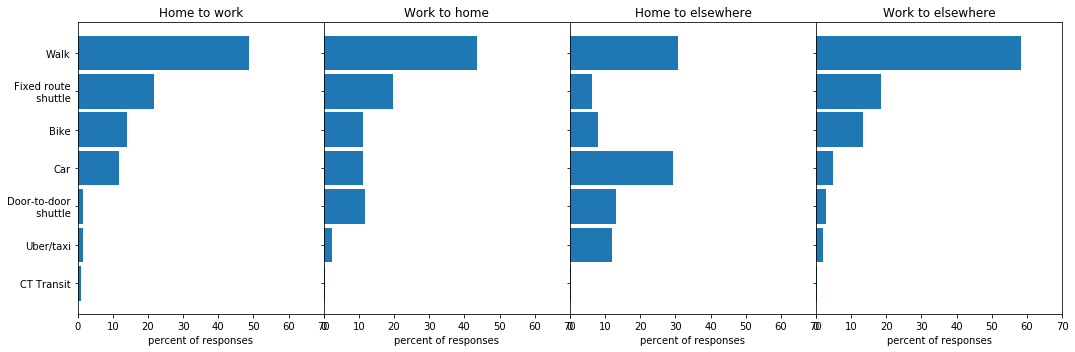

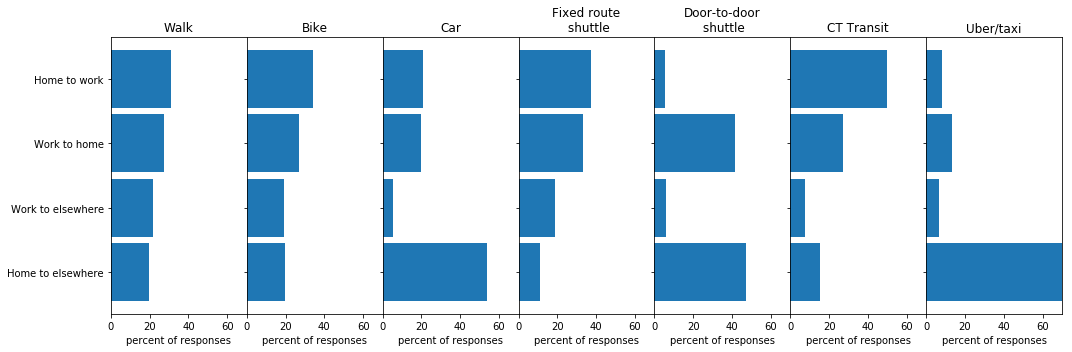

In [817]:
# Compare Question 1 and Question 21

trans =  ['Walk', 'Bike', 'Car', 'Fixed route shuttle', 'Door-to-door shuttle', 'CT Transit', 'Uber/taxi']
methods = ['Home to work', 'Work to home', 'Home to elsewhere', 'Work to elsewhere']

fig1, ax1 = plt.subplots(1, len(methods), sharey=True, figsize=[15,5])
fig2, ax2 = plt.subplots(1, len(trans), sharey=True, figsize=[15,5])
compare_columns(GPSS_DATA, 'Q21', 'Q1', methods, trans, ax=ax1, n_col=6, norm=True)
compare_columns(GPSS_DATA, 'Q1', 'Q21', trans, methods, ax=ax2, n_col=6, norm=True)
for ax in list(ax1) + list(ax2): ax.set_xlim(0, 70)
fig1.tight_layout()
fig2.tight_layout()
fig1.subplots_adjust(wspace=0)
fig2.subplots_adjust(wspace=0)
fig1.savefig('plots/Q21_Q1.png')
fig2.savefig('plots/Q1_Q21.png')


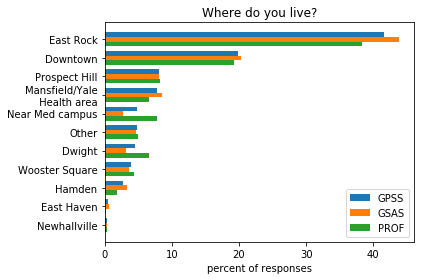

In [805]:
# Question 3: Where do you live?

fig, ax = plt.subplots()
r = ['East Rock', 'Downtown', 'Mansfield/Yale Health area', 'Prospect Hill', 'Wooster Square', 'Dwight', 'Near Med campus', 'Newhallville', 'Hamden', 'East Haven', 'Other']
r = hist_from_column(GPSS_DATA, 'Q3', ax=ax, label='GPSS', responses=r, offset=0.0, width=0.25, sort=True)
hist_from_column(GSAS_DATA, 'Q3', ax=ax, label='GSAS', responses=r, offset=0.25, width=0.25)
hist_from_diff(GPSS_DATA, GSAS_DATA, 'Q3', ax=ax, label='PROF', responses=r, offset=0.5, width=0.25)
ax.set_title('Where do you live?')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q3.png')

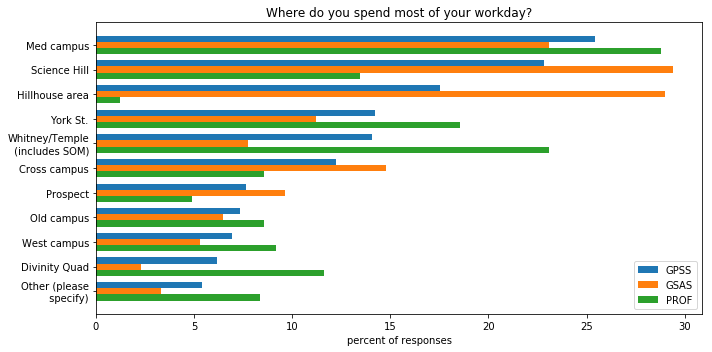

In [806]:
# Question 4: Where do you spend most of your workday?

fig, ax = plt.subplots(figsize=[10,5])
r = hist_from_column(GPSS_DATA, 'Q4', ax=ax, label='GPSS', sort=True, offset=0.0, width=0.25)
hist_from_column(GSAS_DATA, 'Q4', ax=ax, label='GSAS', responses=r, offset=0.25, width=0.25)
hist_from_diff(GPSS_DATA, GSAS_DATA, 'Q4', ax=ax, label='PROF', responses=r, offset=0.5, width=0.25)
ax.set_title('Where do you spend most of your workday?')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q4.png')

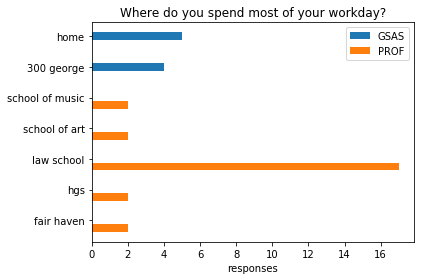

In [807]:
# Question 4: Other (please specify)

fig, ax = plt.subplots()
r = ['law school', 'home', '300 george', 'school of music', 'school of art', 'hgs', 'fair haven']
# r = hist_from_column(GPSS_DATA, 'Q4_11_TEXT', label='GPSS', parse=True, sort=True, ax=ax, norm=False, offset=0.0, width=0.25, responses=r)
r = hist_from_column(GSAS_DATA, 'Q4_11_TEXT', label='GSAS', parse=True, sort=True, ax=ax, norm=False, offset=.25, width=0.25, responses=r)
hist_from_diff(GPSS_DATA, GSAS_DATA, 'Q4_11_TEXT', label='PROF', parse=True, ax=ax, norm=False, offset=0.5, width=0.25, responses=r)
ax.set_title('Where do you spend most of your workday?')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q4_11_TEXT.png')

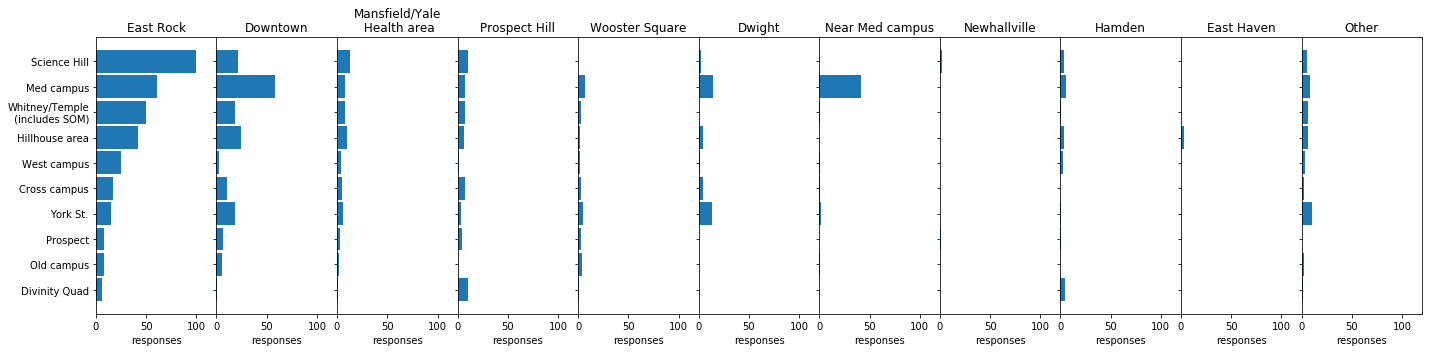

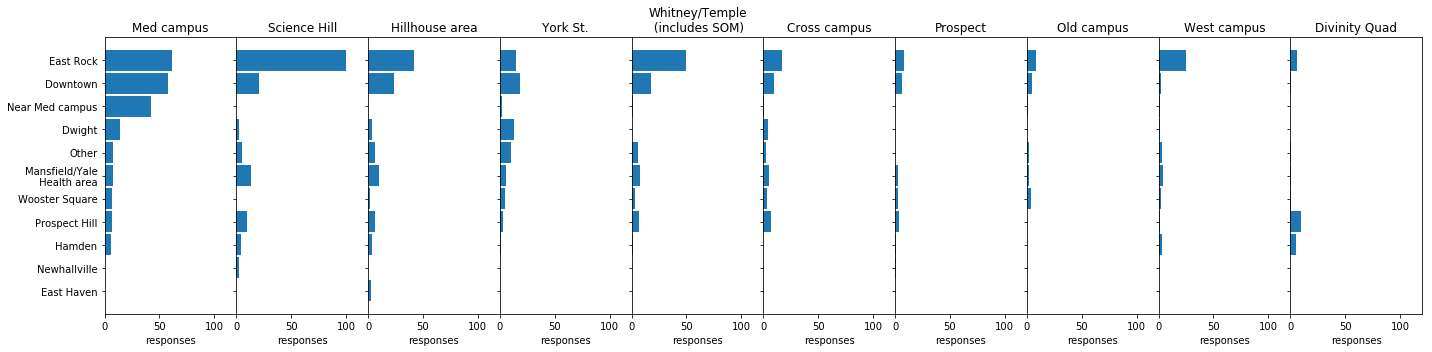

In [808]:
# Compare Question 3 and 4

home =  ['East Rock', 'Downtown', 'Mansfield/Yale Health area', 'Prospect Hill', 'Wooster Square', 'Dwight', 'Near Med campus', 'Newhallville', 'Hamden', 'East Haven', 'Other']
work = ['Med campus', 'Science Hill', 'Hillhouse area', 'York St.', 'Whitney/Temple (includes SOM)', 'Cross campus', 'Prospect', 'Old campus', 'West campus', 'Divinity Quad']

fig1, ax1 = plt.subplots(1, len(home), figsize=[20,5], sharey=True)
fig2, ax2 = plt.subplots(1, len(work), figsize=[20,5], sharey=True)
compare_columns(GPSS_DATA, 'Q3', 'Q4', home, work, ax=ax1, n_col=1) 
compare_columns(GPSS_DATA, 'Q4', 'Q3', work, home, ax=ax2, n_col=1)
for ax in list(ax1) + list(ax2) : ax.set_xlim(0,120)
fig1.tight_layout()
fig2.tight_layout()
fig1.subplots_adjust(wspace=0)
fig2.subplots_adjust(wspace=0)
fig1.savefig('plots/Q3_Q4.png')
fig2.savefig('plots/Q4_Q3.png')


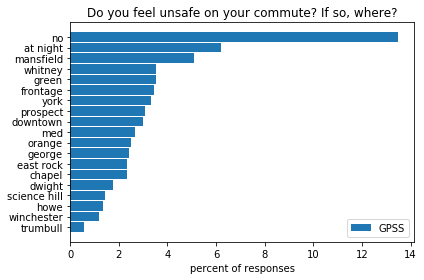

In [4]:
# Question 5: Do you feel unsafe on your commute? If so, where?

fig, ax = plt.subplots()
r = ['no', 'at night', 'mansfield', 'whitney', 'frontage', 'york', 'prospect', 'downtown', 'med', 'science hill', 'east rock', 'orange', 'george', 'chapel', 'dwight', 'howe', 'winchester', 'green', 'trumbull']
r = hist_from_column(GPSS_DATA, 'Q5', label='GPSS', parse=True, sort=True, ax=ax, norm=True, responses=r)
ax.set_title('Do you feel unsafe on your commute? If so, where?')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q5.png')


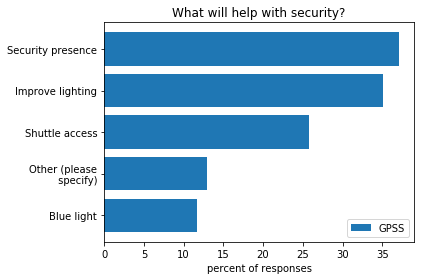

In [740]:
# Question 6: What will help with security?

fig, ax = plt.subplots()
r = ['Security presence', 'Improve lighting', 'Shuttle access', 'Blue light', 'Other (please specify)']
r = hist_from_column(GPSS_DATA, 'Q6', ax=ax, label='GPSS', sort=True, offset=0.0, width=0.8, count_nan=True, responses=r)
# hist_from_column(GSAS_DATA, 'Q6', ax=ax, label='GSAS', responses=r, offset=0.25, width=0.25, count_nan=True)
# hist_from_diff(GPSS_DATA, GSAS_DATA, 'Q6', ax=ax, label='PROF', responses=r, offset=0.5, width=0.25, count_nan=True)
ax.set_title('What will help with security?')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q6.png')

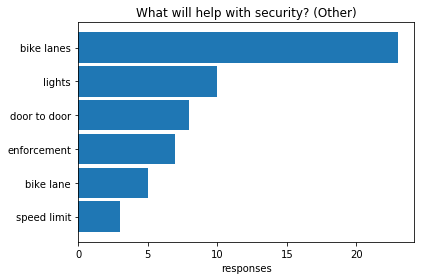

In [729]:
# Question 6_5_TEXT: Other security

fig, ax = plt.subplots()
r = ['bike lanes', 'lights', 'door to door', 'bike lane', 'enforcement', 'speed limit']
r = hist_from_column(GPSS_DATA, 'Q6_5_TEXT', parse=True, sort=True, ax=ax, norm=False, responses=r)
ax.set_title('What will help with security? (Other)')
fig.tight_layout()
fig.savefig('plots/Q6_5_TEXT.png')

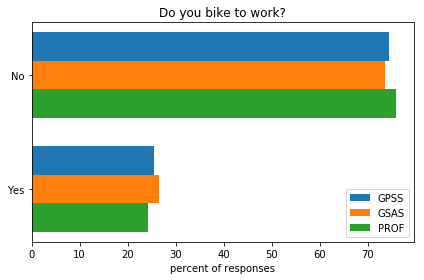

In [730]:
# Question 7: Do you bike to work?

fig, ax = plt.subplots()
r = hist_from_column(GPSS_DATA, 'Q7', ax=ax, label='GPSS', sort=True, offset=0.0, width=0.25)
hist_from_column(GSAS_DATA, 'Q7', ax=ax, label='GSAS', responses=r, offset=0.25, width=0.25)
hist_from_diff(GPSS_DATA, GSAS_DATA, 'Q7', ax=ax, label='PROF', responses=r, offset=0.5, width=0.25)
ax.set_title('Do you bike to work?')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q7.png')

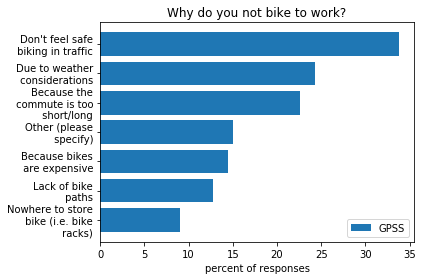

In [731]:
# Question 7B: Why do you not bike to work?

fig, ax = plt.subplots()
# r = ["Don't feel safe biking in traffic", 'Due to weather considerations', 'Because the commute is too short/long', 'Because bikes are expensive', 'Lack of bike paths', 'Nowhere to store bike (i.e. bike racks)']
r = hist_from_column(GPSS_DATA, 'Q7B', ax=ax, label='GPSS', sort=True, offset=0.0, width=0.8, count_nan=True)
# hist_from_column(GSAS_DATA, 'Q7B', ax=ax, label='GSAS', responses=r, offset=0.25, width=0.25, count_nan=True)
# hist_from_diff(GPSS_DATA, GSAS_DATA, 'Q7B', ax=ax, label='PROF', responses=r, offset=0.5, width=0.25, count_nan=True)
ax.set_title('Why do you not bike to work?')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q7B.png')

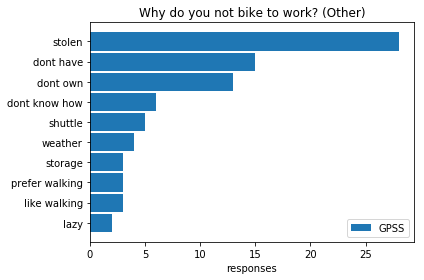

In [732]:
# Question 7B_3_TEXT: Other bike

fig, ax = plt.subplots()
r = ['dont have', 'dont own', 'stolen', 'dont know how', 'shuttle', 'prefer walking', 'storage', 'weather', 'like walking', 'lazy']
r = hist_from_column(GPSS_DATA, 'Q7B_3_TEXT', label='GPSS', parse=True, sort=True, ax=ax, norm=False, responses=r)
ax.set_title('Why do you not bike to work? (Other)')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q7B_3_TEXT.png')


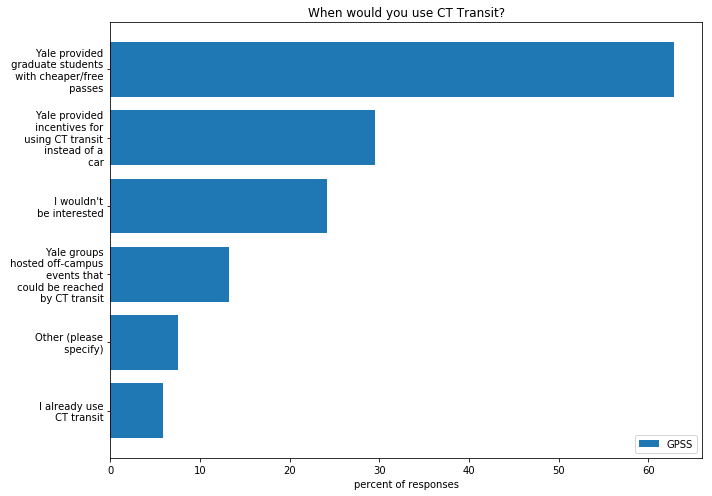

In [733]:
# Question 9: When would you use CT Transit?
r = ['I already use CT transit',
     'Yale provided graduate students with cheaper/free passes',
     'Yale groups hosted off-campus events that could be reached by CT transit',
     " I wouldn't be interested",
     'Yale provided incentives for using CT transit instead of a car',
     'Other (please specify)']

fig, ax = plt.subplots(figsize=[10, 7])
r = hist_from_column(GPSS_DATA, 'Q9', ax=ax, label='GPSS', split=True, responses=r, sort=True, offset=0.0, width=0.8, count_nan=True)
# hist_from_column(GSAS_DATA, 'Q9', ax=ax, label='GSAS', split=True, responses=r, offset=0.25, width=0.25, count_nan=True)
# hist_from_diff(GPSS_DATA, GSAS_DATA, 'Q9', ax=ax, label='PROF', split=True, responses=r, offset=0.5, width=0.25, count_nan=True)
ax.set_title('When would you use CT Transit?')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q9.png')

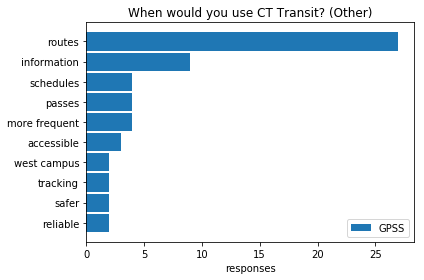

In [734]:
# Question 9_5_TEXT: Other CT Transit

fig, ax = plt.subplots()
r = ['information', 'routes', 'passes', 'schedules', 'more frequent',
     'accessible', 'west campus', 'safer', 'tracking', 'reliable']
r = hist_from_column(GPSS_DATA, 'Q9_5_TEXT', label='GPSS', parse=True, sort=True, ax=ax, norm=False, responses=r)
# print(r)
ax.set_title('When would you use CT Transit? (Other)')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q9_5_TEXT.png')

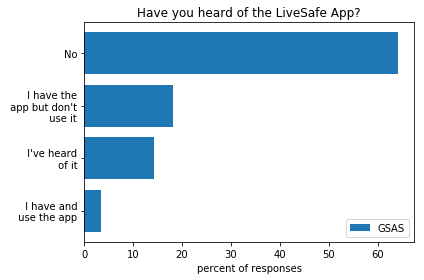

In [735]:
# Question 10: Have you heard of the LiveSafe App?
r = ['No', " I have the app but don't use it", " I've heard of it", " I have and use the app"]
fig, ax = plt.subplots()
r = hist_from_column(GSAS_DATA, 'Q10', ax=ax, label='GSAS', sort=True, width=0.8, responses=r)
ax.set_title('Have you heard of the LiveSafe App?')
ax.legend()
fig.tight_layout()
fig.savefig('plots/Q10.png')

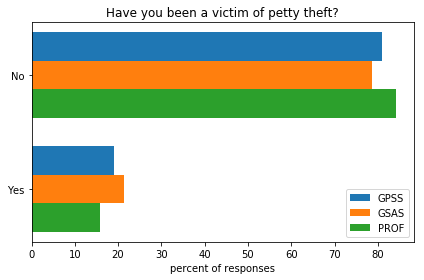

In [736]:
# Question 20: Have you been a victim of petty theft?

fig, ax = plt.subplots()
r = hist_from_column(GPSS_DATA, 'Q20', ax=ax, label='GPSS', sort=True, offset=0.0, width=0.25)
hist_from_column(GSAS_DATA, 'Q20', ax=ax, label='GSAS', responses=r, offset=0.25, width=0.25)
hist_from_diff(GPSS_DATA, GSAS_DATA, 'Q20', ax=ax, label='PROF', responses=r, offset=0.5, width=0.25)
ax.set_title('Have you been a victim of petty theft?')
ax.legend(loc=4)
fig.tight_layout()
fig.savefig('plots/Q20.png')

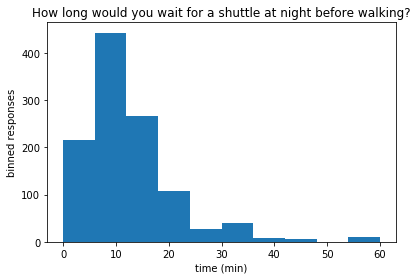

In [737]:
# Question 11: How long would you wait for a shuttle at night before walking?

fig, ax = plt.subplots()
data = list(GPSS_DATA[1:]['Q11_1'])
while np.nan in data:
    data.remove(np.nan)
for i in range(len(data)):
    data[i] = int(data[i])
ax.hist(data)
ax.set_title('How long would you wait for a shuttle at night before walking?')
ax.set_xlabel('time (min)')
ax.set_ylabel('binned responses')
fig.tight_layout()
fig.savefig('plots/Q11_1.png')